In [41]:
import tensorflow as tf

from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Build long-distance time series data


In [6]:
T = 10 # sequence length
D = 1
X = []
Y_short = []
Y_long = []

# XOR problem in 3D
# draw cuboids and shade corresponding 1 to visualize
def get_label(x, i1, i2, i3): # Ensure 2 no adjacent quadrants have the same color 
    if x[i1] < 0 and x[i2] < 0 and x[i3] < 0:
        return 1
    if x[i1] < 0 and x[i2] > 0 and x[i3] > 0:
        return 1
    if x[i1] > 0 and x[i2] < 0 and x[i3] > 0:
        return 1
    if x[i1] > 0 and x[i2] > 0 and x[i3] < 0:
        return 1
    return 0

# Generate random noise data
for t in range(5000):
    x = np.random.randn(T) # array of 10 digits
    y_short = get_label(x, -1, -2, -3) # short distance (RNN don't have to remember for long since data at end)
    y_long = get_label(x, 0, 1, 2) # long distance (RNN have to remember longer since data at beginning)
    
    X.append(x)
    Y_short.append(y_short)
    Y_long.append(y_long)

X = np.array(X)
Y_short = np.array(Y_short)
Y_long = np.array(Y_long)
N = len(X)

### 1 Try with Linear Model

- model will fail because decision boundary is non-linear


In [8]:
output_node = 1 # only 1 class
input = Input(shape=(T, )) # Linear model is T, not T x D
x = Dense(output_node, activation='sigmoid')(input)

linear_model = Model(input, x)
linear_model.compile(
    loss='binary_crossentropy', # for classification
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01),
    metrics=['accuracy']
)

linear_result = linear_model.fit(
    X, Y_short,
    epochs=100,
    validation_split=0.5
)

Epoch 1/100
79/79 [==============================] - 0s 1ms/step - loss: 0.8496 - accuracy: 0.4908 - val_loss: 0.7337 - val_accuracy: 0.4932
Epoch 2/100
79/79 [==============================] - 0s 549us/step - loss: 0.7034 - accuracy: 0.5032 - val_loss: 0.6987 - val_accuracy: 0.4748
Epoch 3/100
79/79 [==============================] - 0s 518us/step - loss: 0.6940 - accuracy: 0.5116 - val_loss: 0.6970 - val_accuracy: 0.4788
Epoch 4/100
79/79 [==============================] - 0s 525us/step - loss: 0.6939 - accuracy: 0.5044 - val_loss: 0.6962 - val_accuracy: 0.4884
Epoch 5/100
79/79 [==============================] - 0s 545us/step - loss: 0.6941 - accuracy: 0.5208 - val_loss: 0.6970 - val_accuracy: 0.4936
Epoch 6/100
79/79 [==============================] - 0s 523us/step - loss: 0.6943 - accuracy: 0.5124 - val_loss: 0.6978 - val_accuracy: 0.4824
Epoch 7/100
79/79 [==============================] - 0s 536us/step - loss: 0.6942 - accuracy: 0.5124 - val_loss: 0.6973 - val_accuracy: 0.5076
E

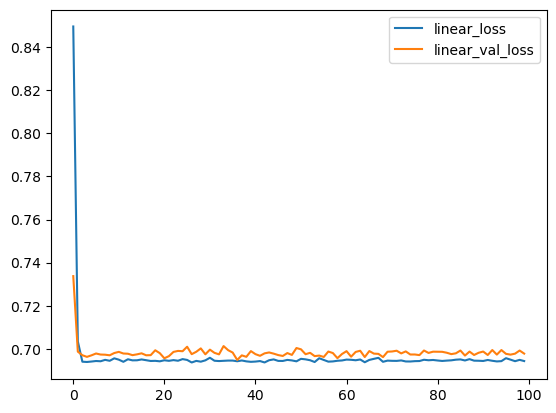

In [9]:
plt.plot(linear_result.history['loss'], label='linear_loss')
plt.plot(linear_result.history['val_loss'], label='linear_val_loss')
plt.legend()
plt.show()

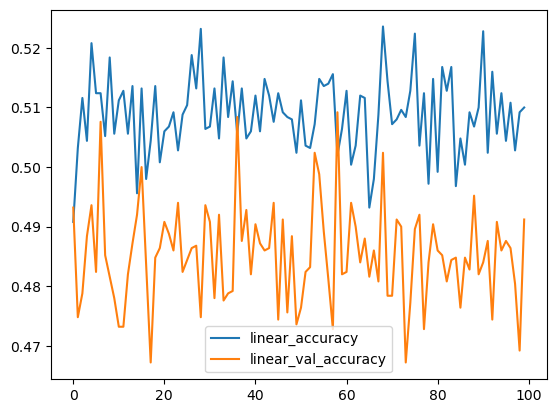

In [10]:
plt.plot(linear_result.history['accuracy'], label='linear_accuracy')
plt.plot(linear_result.history['val_accuracy'], label='linear_val_accuracy')
plt.legend()
plt.show()

### 2 Use SimpleRNN model (Y_short-term - label is near the end of sequence)


In [13]:
M = 5 # No. of hidden nodes
K = 1 # No, of output node(s) - 1 = single prediction
X_rnn = np.expand_dims(X, -1) # make into N x T x D
print(X_rnn.shape)

input = Input(shape=(T, D))
x = SimpleRNN(M)(input)

x = Dense(1, activation='sigmoid')(x)
simple_rnn_model = Model(input, x)
simple_rnn_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01),
    metrics=['accuracy']
)

simple_rnn_result = simple_rnn_model.fit(
    X_rnn, Y_short,
    epochs=200,
    validation_split=0.5 # fraction of training data to set aside for validation, 0.5 for forecasting problem
)

(5000, 10, 1)
Epoch 1/200
79/79 [==============================] - 0s 2ms/step - loss: 0.6980 - accuracy: 0.5540 - val_loss: 0.6738 - val_accuracy: 0.5928
Epoch 2/200
79/79 [==============================] - 0s 895us/step - loss: 0.6521 - accuracy: 0.6636 - val_loss: 0.6237 - val_accuracy: 0.7032
Epoch 3/200
79/79 [==============================] - 0s 884us/step - loss: 0.5943 - accuracy: 0.7260 - val_loss: 0.5665 - val_accuracy: 0.7392
Epoch 4/200
79/79 [==============================] - 0s 898us/step - loss: 0.5381 - accuracy: 0.7652 - val_loss: 0.5195 - val_accuracy: 0.7592
Epoch 5/200
79/79 [==============================] - 0s 915us/step - loss: 0.4872 - accuracy: 0.7960 - val_loss: 0.4658 - val_accuracy: 0.8000
Epoch 6/200
79/79 [==============================] - 0s 979us/step - loss: 0.4342 - accuracy: 0.8232 - val_loss: 0.4128 - val_accuracy: 0.8348
Epoch 7/200
79/79 [==============================] - 0s 932us/step - loss: 0.3799 - accuracy: 0.8588 - val_loss: 0.3594 - val_accu

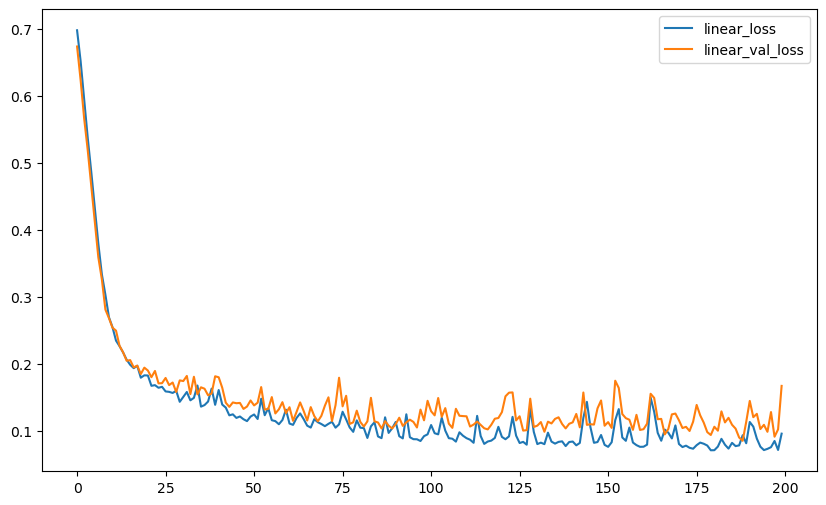

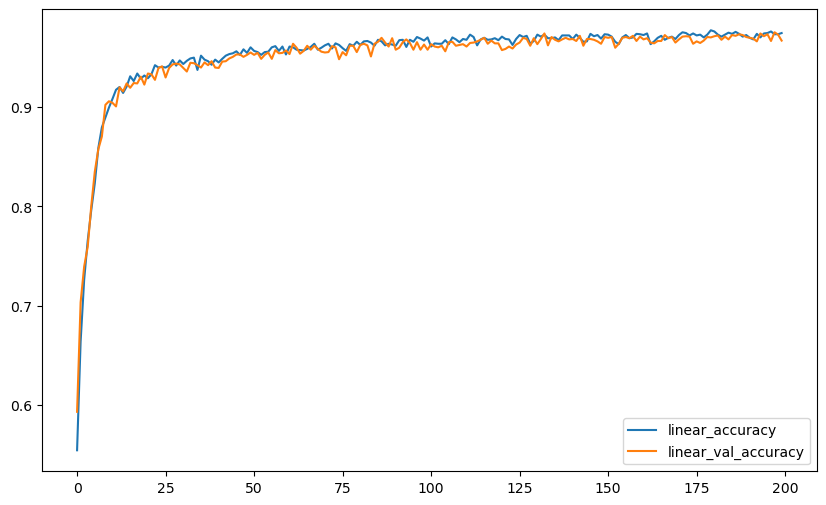

In [20]:
plt.figure(figsize=(10,6))
plt.plot(simple_rnn_result.history['loss'], label='linear_loss')
plt.plot(simple_rnn_result.history['val_loss'], label='linear_val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(simple_rnn_result.history['accuracy'], label='linear_accuracy')
plt.plot(simple_rnn_result.history['val_accuracy'], label='linear_val_accuracy')
plt.legend()
plt.show()

### 2 Use SimpleRNN model (Y_long-term - label is at the start of sequence)


In [21]:
simple_rnn_result = simple_rnn_model.fit(
    X_rnn, Y_long,
    epochs=200,
    validation_split=0.5 # fraction of training data to set aside for validation, 0.5 for forecasting problem
)

Epoch 1/200
79/79 [==============================] - 0s 1ms/step - loss: 3.0590 - accuracy: 0.4904 - val_loss: 1.0556 - val_accuracy: 0.5072
Epoch 2/200
79/79 [==============================] - 0s 928us/step - loss: 0.8801 - accuracy: 0.4884 - val_loss: 0.7561 - val_accuracy: 0.5052
Epoch 3/200
79/79 [==============================] - 0s 903us/step - loss: 0.7504 - accuracy: 0.5028 - val_loss: 0.7118 - val_accuracy: 0.4864
Epoch 4/200
79/79 [==============================] - 0s 906us/step - loss: 0.7169 - accuracy: 0.4724 - val_loss: 0.7080 - val_accuracy: 0.5088
Epoch 5/200
79/79 [==============================] - 0s 894us/step - loss: 0.7109 - accuracy: 0.5052 - val_loss: 0.7204 - val_accuracy: 0.5000
Epoch 6/200
79/79 [==============================] - 0s 883us/step - loss: 0.7080 - accuracy: 0.4836 - val_loss: 0.7015 - val_accuracy: 0.5068
Epoch 7/200
79/79 [==============================] - 0s 915us/step - loss: 0.7070 - accuracy: 0.4896 - val_loss: 0.7004 - val_accuracy: 0.5092
E

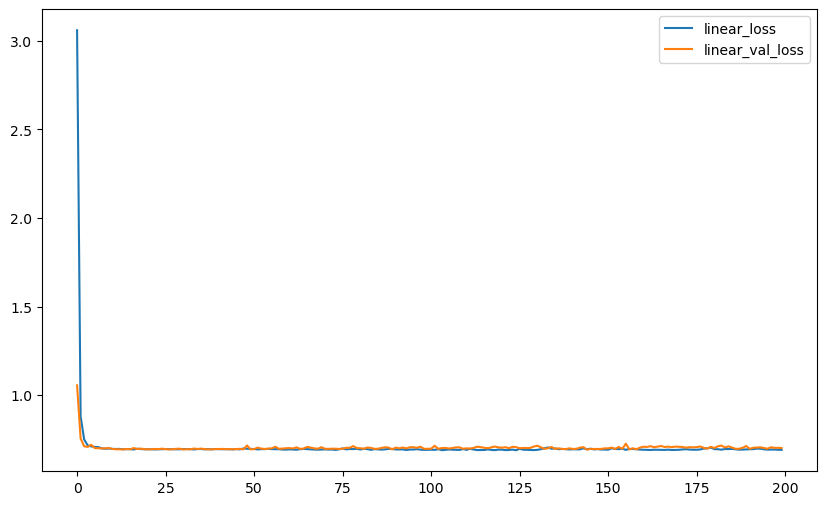

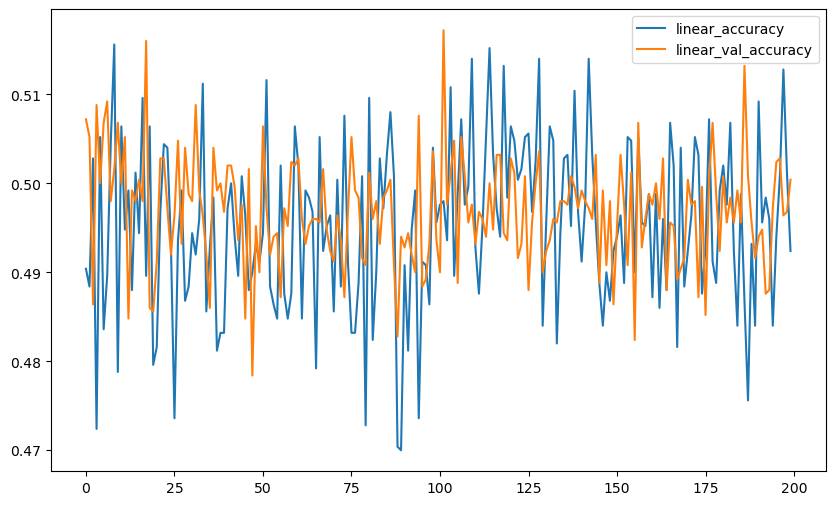

In [22]:
plt.figure(figsize=(10,6))
plt.plot(simple_rnn_result.history['loss'], label='linear_loss')
plt.plot(simple_rnn_result.history['val_loss'], label='linear_val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(simple_rnn_result.history['accuracy'], label='linear_accuracy')
plt.plot(simple_rnn_result.history['val_accuracy'], label='linear_val_accuracy')
plt.legend()
plt.show()

### SimpleRNN has issue with learning when label is at start of sequence

- due to vanishing gradient problem


### 3 Using LSTM to solve Long-Term sequence problem


In [23]:
input = Input(shape=(T, D))
x = LSTM(M)(input)

x = Dense(1, activation='sigmoid')(x)
lstm_model = Model(input, x)
lstm_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01),
    metrics=['accuracy']
)

lstm_result = lstm_model.fit(
    X_rnn, Y_long,
    epochs=200,
    validation_split=0.5 # fraction of training data to set aside for validation, 0.5 for forecasting problem
)

Epoch 1/200
79/79 [==============================] - 1s 3ms/step - loss: 0.6943 - accuracy: 0.5088 - val_loss: 0.6930 - val_accuracy: 0.5116
Epoch 2/200
79/79 [==============================] - 0s 1ms/step - loss: 0.6931 - accuracy: 0.5100 - val_loss: 0.6937 - val_accuracy: 0.5036
Epoch 3/200
79/79 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.5064 - val_loss: 0.6935 - val_accuracy: 0.5028
Epoch 4/200
79/79 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5044 - val_loss: 0.6931 - val_accuracy: 0.5064
Epoch 5/200
79/79 [==============================] - 0s 1ms/step - loss: 0.6930 - accuracy: 0.5052 - val_loss: 0.6941 - val_accuracy: 0.5020
Epoch 6/200
79/79 [==============================] - 0s 1ms/step - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6932 - val_accuracy: 0.5096
Epoch 7/200
79/79 [==============================] - 0s 1ms/step - loss: 0.6928 - accuracy: 0.5104 - val_loss: 0.6926 - val_accuracy: 0.5044
Epoch 8/200
7

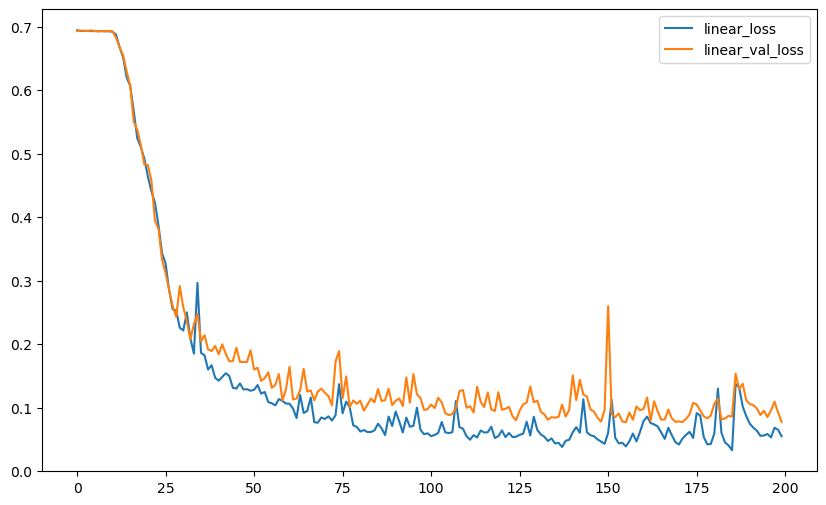

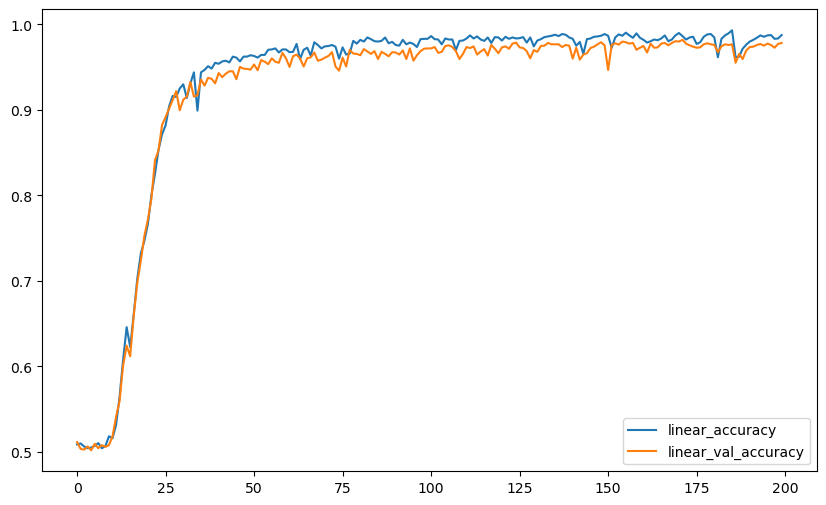

In [24]:
plt.figure(figsize=(10,6))
plt.plot(lstm_result.history['loss'], label='linear_loss')
plt.plot(lstm_result.history['val_loss'], label='linear_val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(lstm_result.history['accuracy'], label='linear_accuracy')
plt.plot(lstm_result.history['val_accuracy'], label='linear_val_accuracy')
plt.legend()
plt.show()

### LSTM is able to tackle vanishing gradient problem when label is located at start of sequence


### Exploring length of sequence before LSTM begins breaking down


In [ ]:
T = 10 # sequence length
D = 1
X = []
Y_short = []
Y_long = []

# XOR problem in 3D
# draw cuboids and shade corresponding 1 to visualize
def get_label(x, i1, i2, i3): # Ensure 2 no adjacent quadrants have the same color 
    if x[i1] < 0 and x[i2] < 0 and x[i3] < 0:
        return 1
    if x[i1] < 0 and x[i2] > 0 and x[i3] > 0:
        return 1
    if x[i1] > 0 and x[i2] < 0 and x[i3] > 0:
        return 1
    if x[i1] > 0 and x[i2] > 0 and x[i3] < 0:
        return 1
    return 0

# Generate random noise data
for t in range(5000):
    x = np.random.randn(T) # array of 10 digits
    y_short = get_label(x, -1, -2, -3) # short distance (RNN don't have to remember for long since data at end)
    y_long = get_label(x, 0, 1, 2) # long distance (RNN have to remember longer since data at beginning)
    
    X.append(x)
    Y_short.append(y_short)
    Y_long.append(y_long)

X = np.array(X)
Y_short = np.array(Y_short)
Y_long = np.array(Y_long)
N = len(X)

In [27]:
def generate_long_term_data(T):
    X = []
    Y = []
    
    for t in range(2000):
        x = np.random.randn(T)
        y = get_label(x, 0, 1, 2)
        
        X.append(x)
        Y.append(y)
        
    X = np.array(X)
    X = np.expand_dims(X, -1) # make into format suitable for LSTM
    Y = np.array(Y)
    
    return X, Y



In [28]:

results = {}
for T in range(20, 101, 10):
    X, Y = generate_long_term_data(T)
    
    lstm_result = lstm_model.fit(
    X, Y,
    epochs=200,
    validation_split=0.5 # fraction of training data to set aside for validation, 0.5 for forecasting problem
    )
    
    val_loss =  lstm_result.history['val_loss']
    val_acc = lstm_result.history['val_accuracy']
    
    results[T] = {
        "val_loss": val_loss,
        "val_acc": val_acc
    }
    
    print(f"Complete training with sequence length {T} | val_acc: {val_acc} | val_loss: {val_loss}")
    
    

Epoch 1/200
32/32 [==============================] - 1s 7ms/step - loss: 0.2198 - accuracy: 0.9510 - val_loss: 0.2210 - val_accuracy: 0.9470
Epoch 2/200
32/32 [==============================] - 0s 2ms/step - loss: 0.2267 - accuracy: 0.9490 - val_loss: 0.2192 - val_accuracy: 0.9440
Epoch 3/200
32/32 [==============================] - 0s 2ms/step - loss: 0.2148 - accuracy: 0.9460 - val_loss: 0.2590 - val_accuracy: 0.9280
Epoch 4/200
32/32 [==============================] - 0s 2ms/step - loss: 0.2276 - accuracy: 0.9380 - val_loss: 0.1792 - val_accuracy: 0.9520
Epoch 5/200
32/32 [==============================] - 0s 2ms/step - loss: 0.2067 - accuracy: 0.9480 - val_loss: 0.3008 - val_accuracy: 0.9160
Epoch 6/200
32/32 [==============================] - 0s 2ms/step - loss: 0.2934 - accuracy: 0.9130 - val_loss: 0.2253 - val_accuracy: 0.9450
Epoch 7/200
32/32 [==============================] - 0s 2ms/step - loss: 0.2301 - accuracy: 0.9400 - val_loss: 0.1873 - val_accuracy: 0.9540
Epoch 8/200
3

In [39]:
for k, v in results.items():
    print(v)

{'val_loss': [0.22096598148345947, 0.2191571742296219, 0.25897935032844543, 0.1791679710149765, 0.3007819652557373, 0.22531254589557648, 0.18730442225933075, 0.19313693046569824, 0.18951912224292755, 0.185366690158844, 0.18890134990215302, 0.18061815202236176, 0.16609637439250946, 0.13956642150878906, 0.14434075355529785, 0.27407658100128174, 0.23906299471855164, 0.21605540812015533, 0.21622410416603088, 0.22089502215385437, 0.22397920489311218, 0.20259948074817657, 0.25326958298683167, 0.22496794164180756, 0.22105595469474792, 0.22888699173927307, 0.23087824881076813, 0.4531526565551758, 0.39902621507644653, 0.3639705181121826, 0.3440389931201935, 0.33086755871772766, 0.3289959728717804, 0.32193538546562195, 0.3207969069480896, 0.31012171506881714, 0.3062155544757843, 0.3607763648033142, 0.565605103969574, 0.3688106834888458, 0.3429103195667267, 0.33016300201416016, 0.3187309205532074, 0.3001593053340912, 0.2983608543872833, 0.28922244906425476, 0.28041890263557434, 0.2854620218276977

In [40]:
for k, v in results.items():
    v_loss = np.array(v['val_loss'])
    v_acc = np.array(v['val_acc'])
    v_loss_mean = np.mean(v_loss)
    v_accuracy_mean = np.mean(v_acc)
    print(f" Sequence: {k} | Average Loss: {v_loss_mean} | Average Accuracy: {v_accuracy_mean}")

 Sequence: 20 | Average Loss: 0.33383528508245947 | Average Accuracy: 0.8659999999403953
 Sequence: 30 | Average Loss: 0.43823287859559057 | Average Accuracy: 0.7738150006532669
 Sequence: 40 | Average Loss: 0.46090323880314826 | Average Accuracy: 0.7928200024366379
 Sequence: 50 | Average Loss: 0.6053344687819481 | Average Accuracy: 0.6676799997687339
 Sequence: 60 | Average Loss: 0.5816100445389748 | Average Accuracy: 0.7106499993801116
 Sequence: 70 | Average Loss: 0.44372370406985284 | Average Accuracy: 0.8165400004386902
 Sequence: 80 | Average Loss: 0.4018221299350262 | Average Accuracy: 0.8146699991822243
 Sequence: 90 | Average Loss: 0.5484304253757 | Average Accuracy: 0.7113999983668328
 Sequence: 100 | Average Loss: 0.4997831292450428 | Average Accuracy: 0.7560100001096726


### Around Sequence 50, LSTM breaks down


### Try LSTM with GlobalMaxPooling with sequence length = 50


### Theory

- RNN / LSTM in general calculates every h-i for every timestep but returns only final hidden state as prediction hT

  - this hT will be of size M
  - (No. of hidden nodes) [hT_1, hT_2 ... hT_M]

- if return_sequences=True -> returns h-i for every timestep (No. of timesteps = T)
  - this will be of size (T x M)
  - [h1_1 ... h1_M], [h2_1 ... h2_M] ... [hT_1 ... hT_M]

##### What to do with T x M array of all hidden states calculation?

    - perform GlobalMaxPooling1D
    - collapse temporal dimension (T) into single (max) value across all timesteps
    - summarizes the most prominent features
    - this, output of hidden states will still be size M but hMax instead of hT


In [51]:
D

1

In [54]:
T = 50
X_50, Y_50 = generate_long_term_data(T)
M = 5 # No. hidden nodes
K = 1 # No. of output nodes

input = Input(shape=(T, D))

x = LSTM(M, return_sequences=True)(input)
x = GlobalMaxPooling1D()(x) # element-wise max operation

x = Dense(K, activation='sigmoid')(x)

lstm_max_pooled_model = Model(input, x)
lstm_max_pooled_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01),
    metrics=['accuracy']
)

lstm_max_pooled_result = lstm_max_pooled_model.fit(
    X_50, Y_50,
    epochs=200,
    validation_split=0.5
)

Epoch 1/200
32/32 [==============================] - 1s 9ms/step - loss: 0.6922 - accuracy: 0.5410 - val_loss: 0.6964 - val_accuracy: 0.4870
Epoch 2/200
32/32 [==============================] - 0s 5ms/step - loss: 0.6910 - accuracy: 0.5450 - val_loss: 0.6993 - val_accuracy: 0.4870
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5450 - val_loss: 0.6951 - val_accuracy: 0.4870
Epoch 4/200
32/32 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5420 - val_loss: 0.6983 - val_accuracy: 0.4870
Epoch 5/200
32/32 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5450 - val_loss: 0.6977 - val_accuracy: 0.4870
Epoch 6/200
32/32 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.5450 - val_loss: 0.7011 - val_accuracy: 0.4870
Epoch 7/200
32/32 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5450 - val_loss: 0.6990 - val_accuracy: 0.4870
Epoch 8/200
3

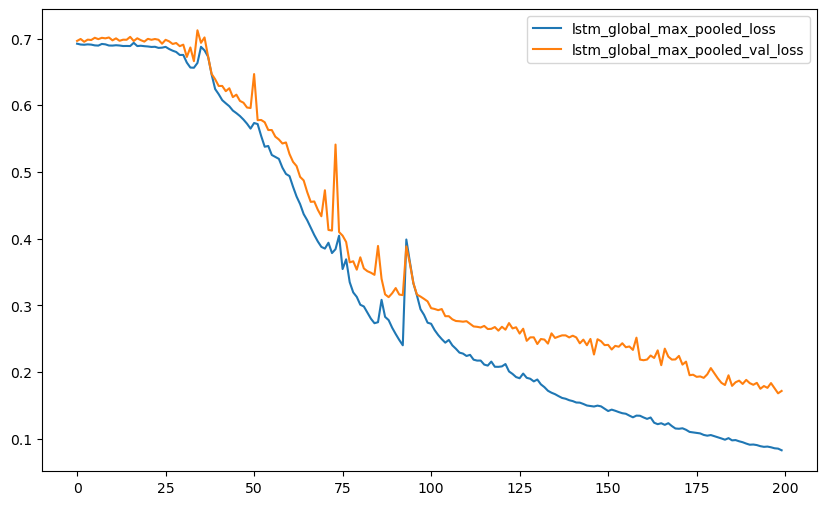

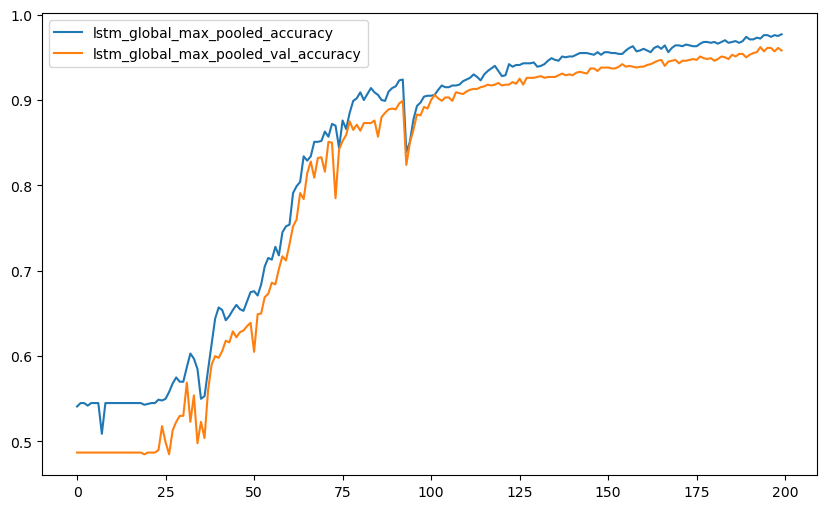

In [56]:
plt.figure(figsize=(10,6))
plt.plot(lstm_max_pooled_result.history['loss'], label='lstm_global_max_pooled_loss')
plt.plot(lstm_max_pooled_result.history['val_loss'], label='lstm_global_max_pooled_val_loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(lstm_max_pooled_result.history['accuracy'], label='lstm_global_max_pooled_accuracy')
plt.plot(lstm_max_pooled_result.history['val_accuracy'], label='lstm_global_max_pooled_val_accuracy')
plt.legend()
plt.show()

### GlobalMaxPooled LSTM is able to learn even if sequence is very long (50)

    - reduces computational load by reducing dimensions
    - identify only most dominant feature from each h
    -


### Further Explorations

- Explore consequence when label data is further apart instead of consecutive index

  - i.e 0, 5, 10 instead of 1, 2, 3

- Explore how performnace of globalMaxPooling for SimpleRNN and GRU

- Explore stacking LSTMs unit
